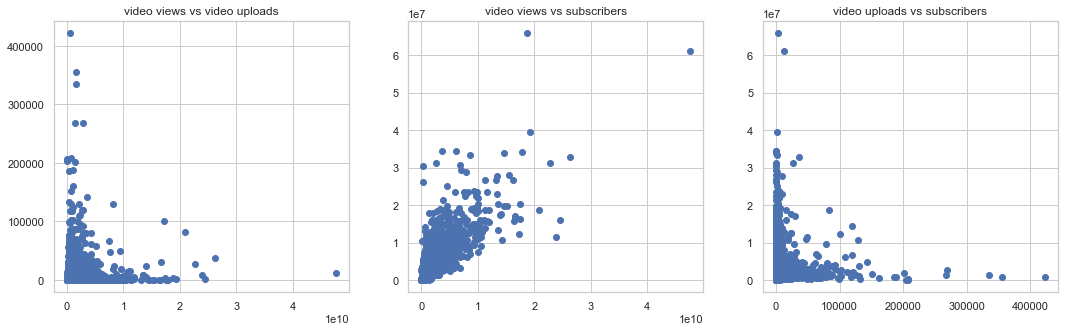

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

youtube_df = pd.read_sql_query('select * from youtube',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# we're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]
        
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["Video views"], youtube_df["Video Uploads"])
plt.title("video views vs video uploads")

plt.subplot(1,3,2)
plt.scatter(youtube_df["Video views"], youtube_df["Subscribers"])
plt.title("video views vs subscribers")

plt.subplot(1,3,3)
plt.scatter(youtube_df["Video Uploads"], youtube_df["Subscribers"])
plt.title("video uploads vs subscribers")

plt.show()

In the second scatterplot, we see a positive relationship between the video views and the number of subscribers. Now, let's look at the relationship between different pairs of student test scores:

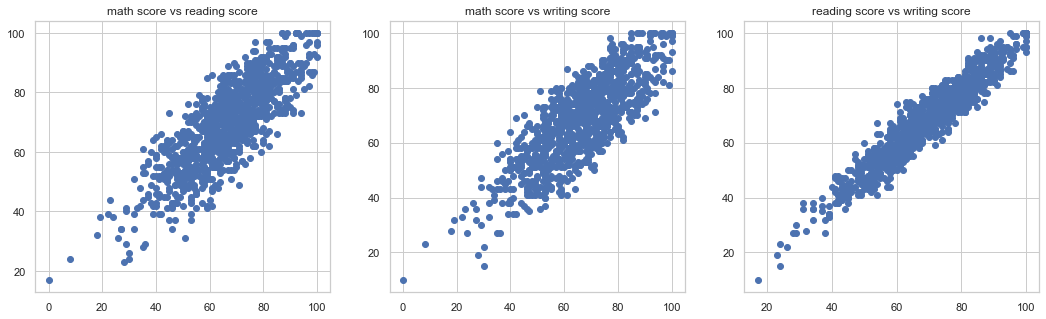

In [3]:
postgres_db = 'studentsperformance'

engine2 = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine2)

# no need for an open connection, 
# as we're only doing a single query
engine2.dispose()

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(student_df["math score"], student_df["reading score"])
plt.title("math score vs reading score")

plt.subplot(1,3,2)
plt.scatter(student_df["math score"], student_df["writing score"])
plt.title("math score vs writing score")

plt.subplot(1,3,3)
plt.scatter(student_df["reading score"], student_df["writing score"])
plt.title("reading score vs writing score")

plt.show()

Oops! Success appears to be not due to chance, but rather hard work. We see there are positive relationships between all the score types.

In [4]:
# get correlation matrix
youtube_df.corr()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
Video Uploads,1.000000,0.011329,0.092423,0.473634,0.012593,0.134971
Subscribers,0.011329,1.000000,0.784449,0.082880,0.778046,0.626605
Video views,0.092423,0.784449,1.000000,0.219291,0.578920,0.700070
winsorized_uploads,0.473634,0.082880,0.219291,1.000000,0.097699,0.307744
winsorized_subscribers,0.012593,0.778046,0.578920,0.097699,1.000000,0.743256
winsorized_views,0.134971,0.626605,0.700070,0.307744,0.743256,1.000000


In [5]:
# get correlation matrix
student_df.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


Here we can see the correlation between video views and subscribers is around 0.78, and that the correlation between the reading and writing scores is higher than any other combination.

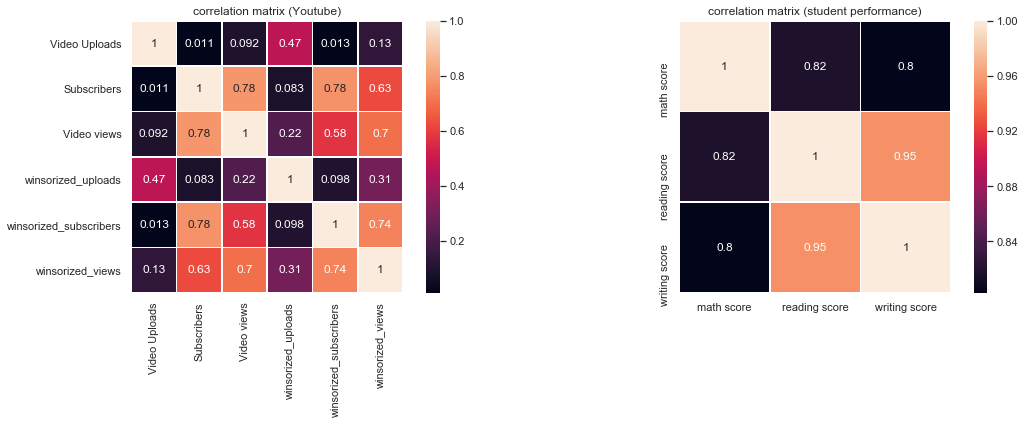

In [8]:
# make the correlation matrices.
corrmat_youtube = youtube_df.corr()

corrmat_student = student_df.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_youtube, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Youtube)")

plt.subplot(1,2,2)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (student performance)")

plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.


In [9]:
# derive averages by group
youtube_df.groupby("Grade").mean()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
Grade,,,,,,
A,5353.923340,4.931878e+06,2.356715e+09,1675.311890,3398754.5,1.447002e+09
A+,16547.927734,1.150483e+07,6.053121e+09,2729.877930,5061679.0,2.088445e+09
A++,37450.699219,2.228176e+07,2.119909e+10,4673.700195,5590006.0,2.468241e+09
A-,4136.514648,2.784051e+06,1.041149e+09,1319.476562,2329109.5,8.810693e+08
B+,2987.168457,1.620060e+06,5.259158e+08,1120.130737,1513429.0,5.085668e+08


As we can see, there are substantial differences in the means of the variables across grade groups.

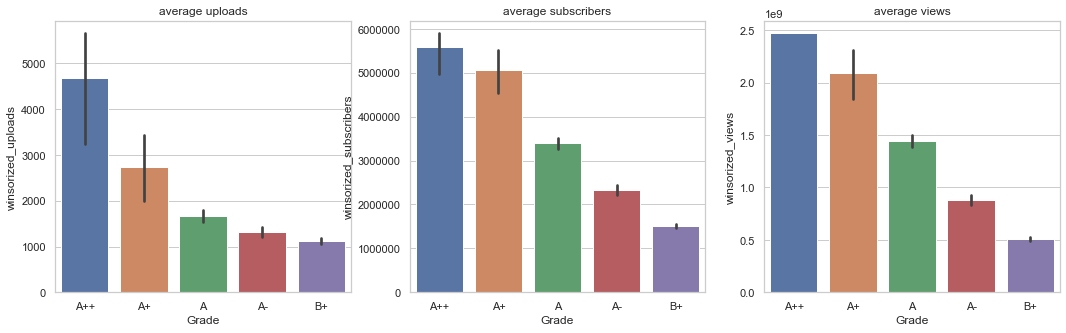

In [10]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_uploads"])
plt.title("average uploads")

plt.subplot(1,3,2)
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_subscribers"])
plt.title("average subscribers")

plt.subplot(1,3,3)
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_views"])
plt.title("average views")

plt.show()

As we can see, averages decrease as the grade lowers. However, visualizing differences is not a formal way of stating that there are significant differences across categories! For this, we need to use a proper statistical test, such as a t-test or ANOVA. So, let's use the t-test to learn whether the differences are statistically significant:

In [12]:
# Test whether group differences are significant.
grades = youtube_df["Grade"].unique()
print(grades)
grouped_df = youtube_df.groupby("Grade")
print( youtube_df.groupby("Grade"))
for var in ["winsorized_uploads", "winsorized_subscribers", "winsorized_views"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(grades)):
        for j in range(i+1, len(grades)):
            print("t-test between groups {0} and {1}:".format(grades[i], grades[j]))
            print(stats.ttest_ind(
                youtube_df[youtube_df["Grade"]==grades[i]][var], 
                youtube_df[youtube_df["Grade"]==grades[j]][var]
            ))

['A++' 'A+' 'A' 'A-' 'B+']
------------------------------------------------
Comparisons for variable: winsorized_uploads
------------------------------------------------
t-test between groups A++ and A+:
Ttest_indResult(statistic=2.3701079407396466, pvalue=0.021763510628877547)
t-test between groups A++ and A:
Ttest_indResult(statistic=4.635430579419143, pvalue=4.046912486918512e-06)
t-test between groups A++ and A-:
Ttest_indResult(statistic=5.849570829755956, pvalue=6.610430711945347e-09)
t-test between groups A++ and B+:
Ttest_indResult(statistic=6.895263475627788, pvalue=6.542432119894545e-12)
t-test between groups A+ and A:
Ttest_indResult(statistic=3.226986347537072, pvalue=0.0012914866839059097)
t-test between groups A+ and A-:
Ttest_indResult(statistic=4.847071421048167, pvalue=1.4393742004398387e-06)
t-test between groups A+ and B+:
Ttest_indResult(statistic=6.2504538443070645, pvalue=4.672660044879273e-10)
t-test between groups A and A-:
Ttest_indResult(statistic=4.1344069090

Some differences are statistically significant and some are not.

In [13]:
# print first few observations
student_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [14]:
# create crosstab: gender by race/ethnicity
count_table = pd.crosstab(student_df["gender"], student_df["race/ethnicity"])
count_table

race/ethnicity,group A,group B,group C,group D,group E
gender,,,,,
female,36,104,180,129,69
male,53,86,139,133,71


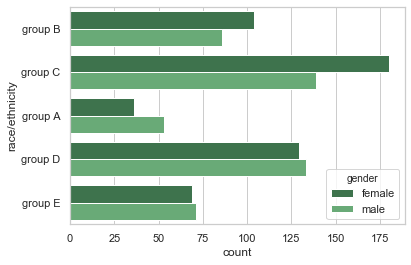

In [16]:
# Plot counts for each combination of levels.
sns.countplot(y="race/ethnicity", hue="gender", data=student_df, palette="Greens_d")
plt.show()

In [17]:
# Test will return a chi-square test statistic and a p-value. Like the t-test,
# the chi-square is compared against a distribution (the chi-square
# distribution) to determine whether the group size differences are large
# enough to reflect differences in the population.
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=181.70000000000002, pvalue=2.237210012745866e-34)
